In [2]:
import pandas as pd
import numpy as np
import os

# Downloading the Dataset

In [3]:
# Define the column names for NSL-KDD dataset
# duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,difficulty_level
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 
    'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 
    'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
    'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'target', 'difficulty_level'
]

# download the dataset
train_url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.txt"
train_df = pd.read_csv(train_url, header=None)
print(f"Training data shape: {train_df.shape}")

test_url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.txt"
test_df = pd.read_csv(test_url, header=None)
print(f"Training data shape: {test_df.shape}")

# save to CSV files
train_df.to_csv('NSL_KDD_Train.csv', index=False)
test_df.to_csv('NSL_KDD_Test.csv', index=False)

Training data shape: (125973, 43)
Training data shape: (22544, 43)


# Pre-process the data

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import warnings

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
train_df = pd.read_csv('NSL_KDD_Train.csv')
test_df = pd.read_csv('NSL_KDD_Train.csv')

In [11]:
# let make it binary classification task
train_df['target'] = train_df['target'].apply(lambda x: 0 if x == 'normal' else 1)
test_df['target'] = test_df['target'].apply(lambda x: 0 if x == 'normal' else 1)

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [ ]:
# Basic dataset info
def explore_data(df, name="Dataset"):
    print(f"\n{'='*50}")
    print(f"🔍 EXPLORING {name}")
    print(f"{'='*50}")
    
    print(f"Shape: {df.shape}")
    print(f"\n📊 Data Types:")
    print(df.dtypes.value_counts())
    
    print(f"\n🎯 Target Distribution:")
    print(df['target'].value_counts())
    
    print(f"\n❓ Missing Values:")
    missing = df.isnull().sum()
    print(missing[missing > 0])
    
    print(f"\n📈 Basic Statistics:")
    print(df.describe().T)

explore_data(train_df, "TRAINING DATA")
explore_data(test_df, "TEST DATA")


🔍 EXPLORING TRAINING DATA
Shape: (125973, 43)

📊 Data Types:
int64      25
float64    15
object      3
Name: count, dtype: int64

🎯 Target Distribution:
target
0    67343
1    58630
Name: count, dtype: int64

❓ Missing Values:
Series([], dtype: int64)

📈 Basic Statistics:
                                count          mean           std  min    25%  \
duration                     125973.0    287.144650  2.604515e+03  0.0   0.00   
src_bytes                    125973.0  45566.743000  5.870331e+06  0.0   0.00   
dst_bytes                    125973.0  19779.114421  4.021269e+06  0.0   0.00   
land                         125973.0      0.000198  1.408607e-02  0.0   0.00   
wrong_fragment               125973.0      0.022687  2.535300e-01  0.0   0.00   
urgent                       125973.0      0.000111  1.436603e-02  0.0   0.00   
hot                          125973.0      0.204409  2.149968e+00  0.0   0.00   
num_failed_logins            125973.0      0.001222  4.523914e-02  0.0   0.00 

In [18]:
label_encoders = {}
categorical_columns =  ['protocol_type', 'service', 'flag']

for col in categorical_columns:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.fit_transform(test_df[col])
    label_encoders[col] = le

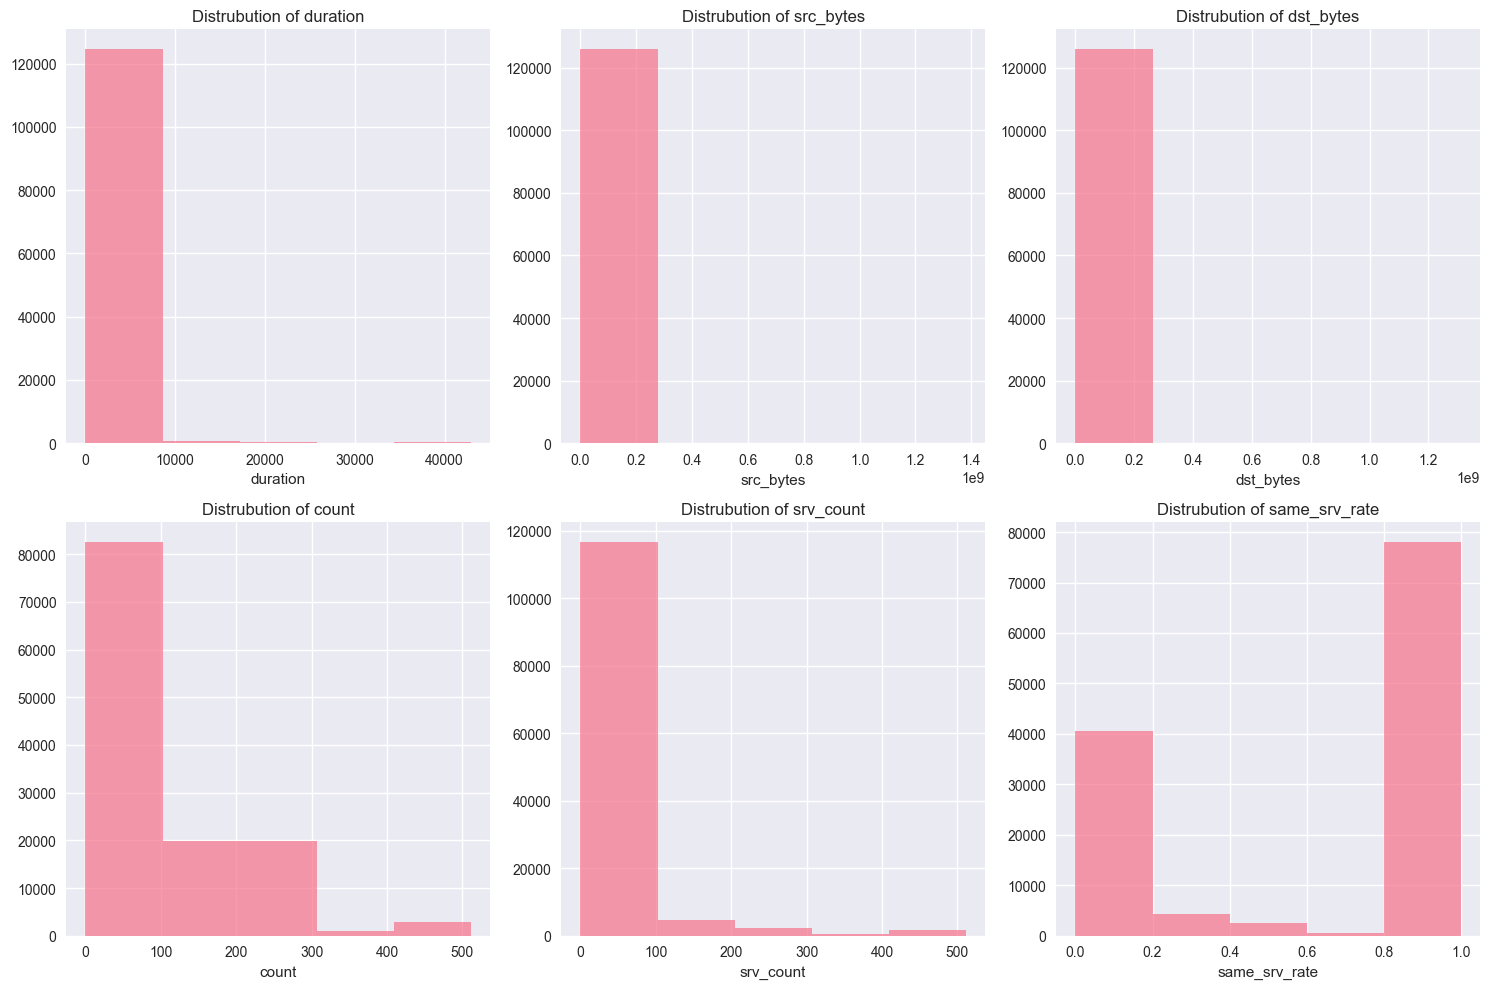

In [ ]:
key_features = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'same_srv_rate']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(key_features):
    train_df[feature].hist(bins=5, ax=axes[i], alpha=0.7)
    axes[i].set_title(f'Distrubution of {feature}')
    axes[i].set_xlabel(feature)

plt.tight_layout()
plt.show()

<Figure size 2000x4000 with 0 Axes>

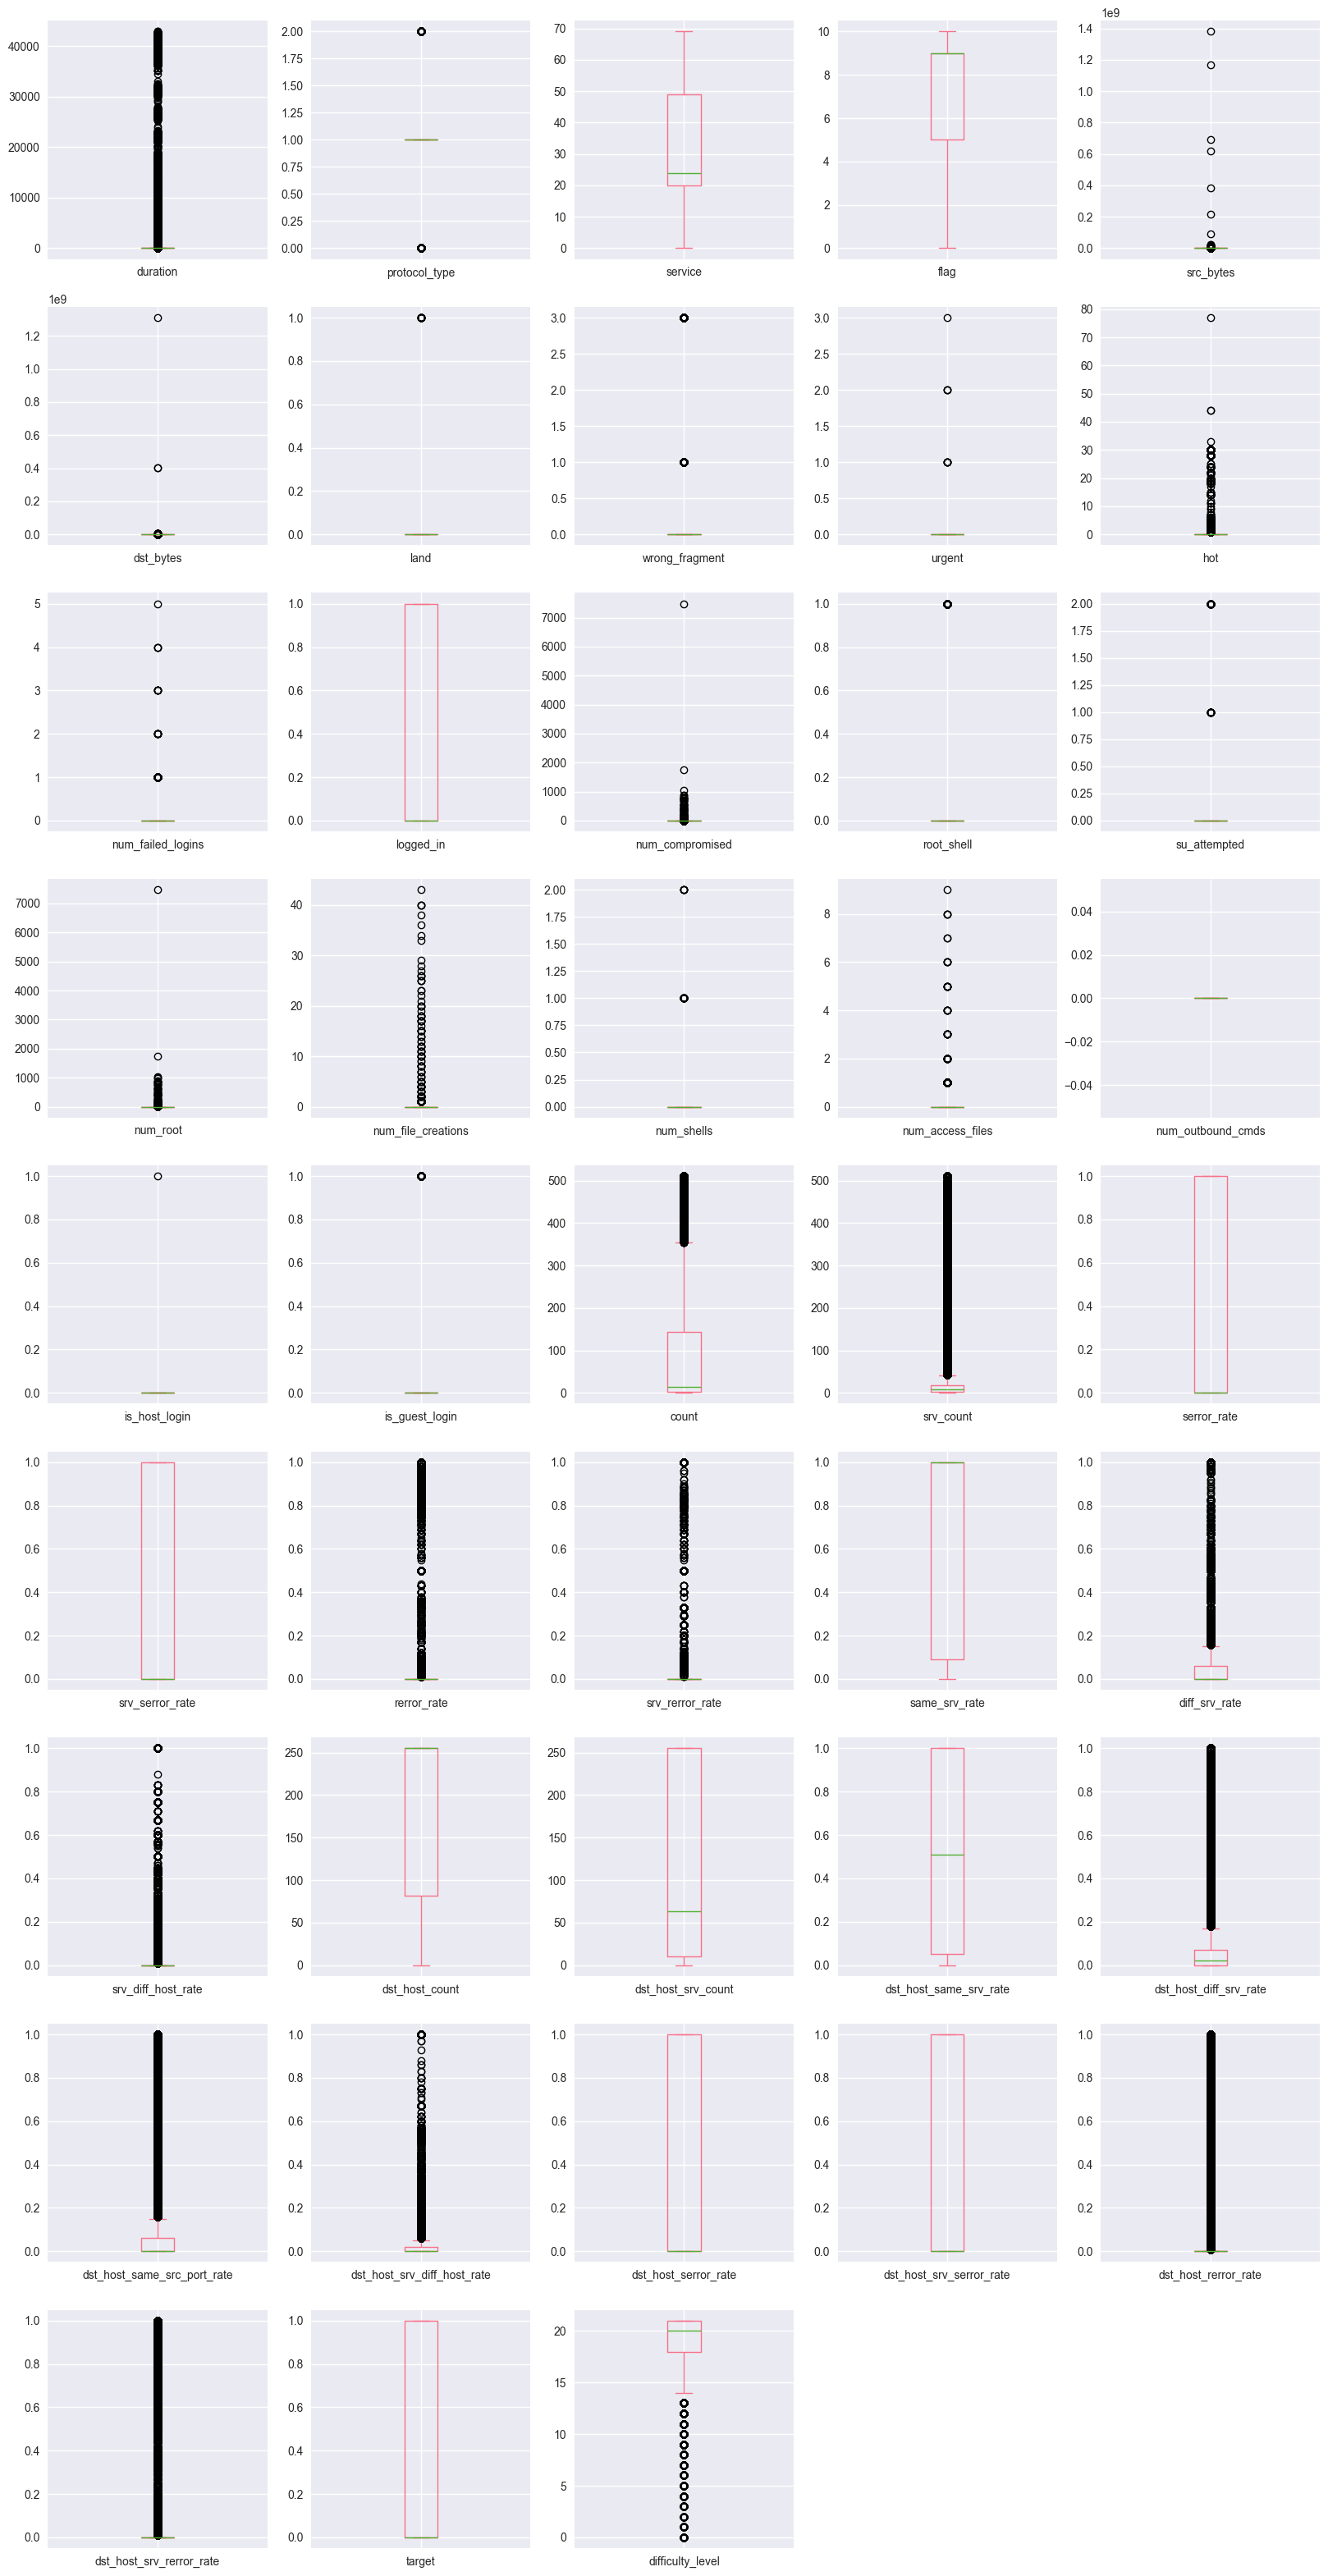

In [ ]:
plt.figure(figsize=(20, 40))
train_df.plot(kind='box', subplots=True, layout=(9, 5), figsize=(20, 40))
plt.show()

array([[<Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'protocol_type'}>,
        <Axes: title={'center': 'service'}>,
        <Axes: title={'center': 'flag'}>,
        <Axes: title={'center': 'src_bytes'}>,
        <Axes: title={'center': 'dst_bytes'}>,
        <Axes: title={'center': 'land'}>],
       [<Axes: title={'center': 'wrong_fragment'}>,
        <Axes: title={'center': 'urgent'}>,
        <Axes: title={'center': 'hot'}>,
        <Axes: title={'center': 'num_failed_logins'}>,
        <Axes: title={'center': 'logged_in'}>,
        <Axes: title={'center': 'num_compromised'}>,
        <Axes: title={'center': 'root_shell'}>],
       [<Axes: title={'center': 'su_attempted'}>,
        <Axes: title={'center': 'num_root'}>,
        <Axes: title={'center': 'num_file_creations'}>,
        <Axes: title={'center': 'num_shells'}>,
        <Axes: title={'center': 'num_access_files'}>,
        <Axes: title={'center': 'num_outbound_cmds'}>,
        <Axes: title={'center

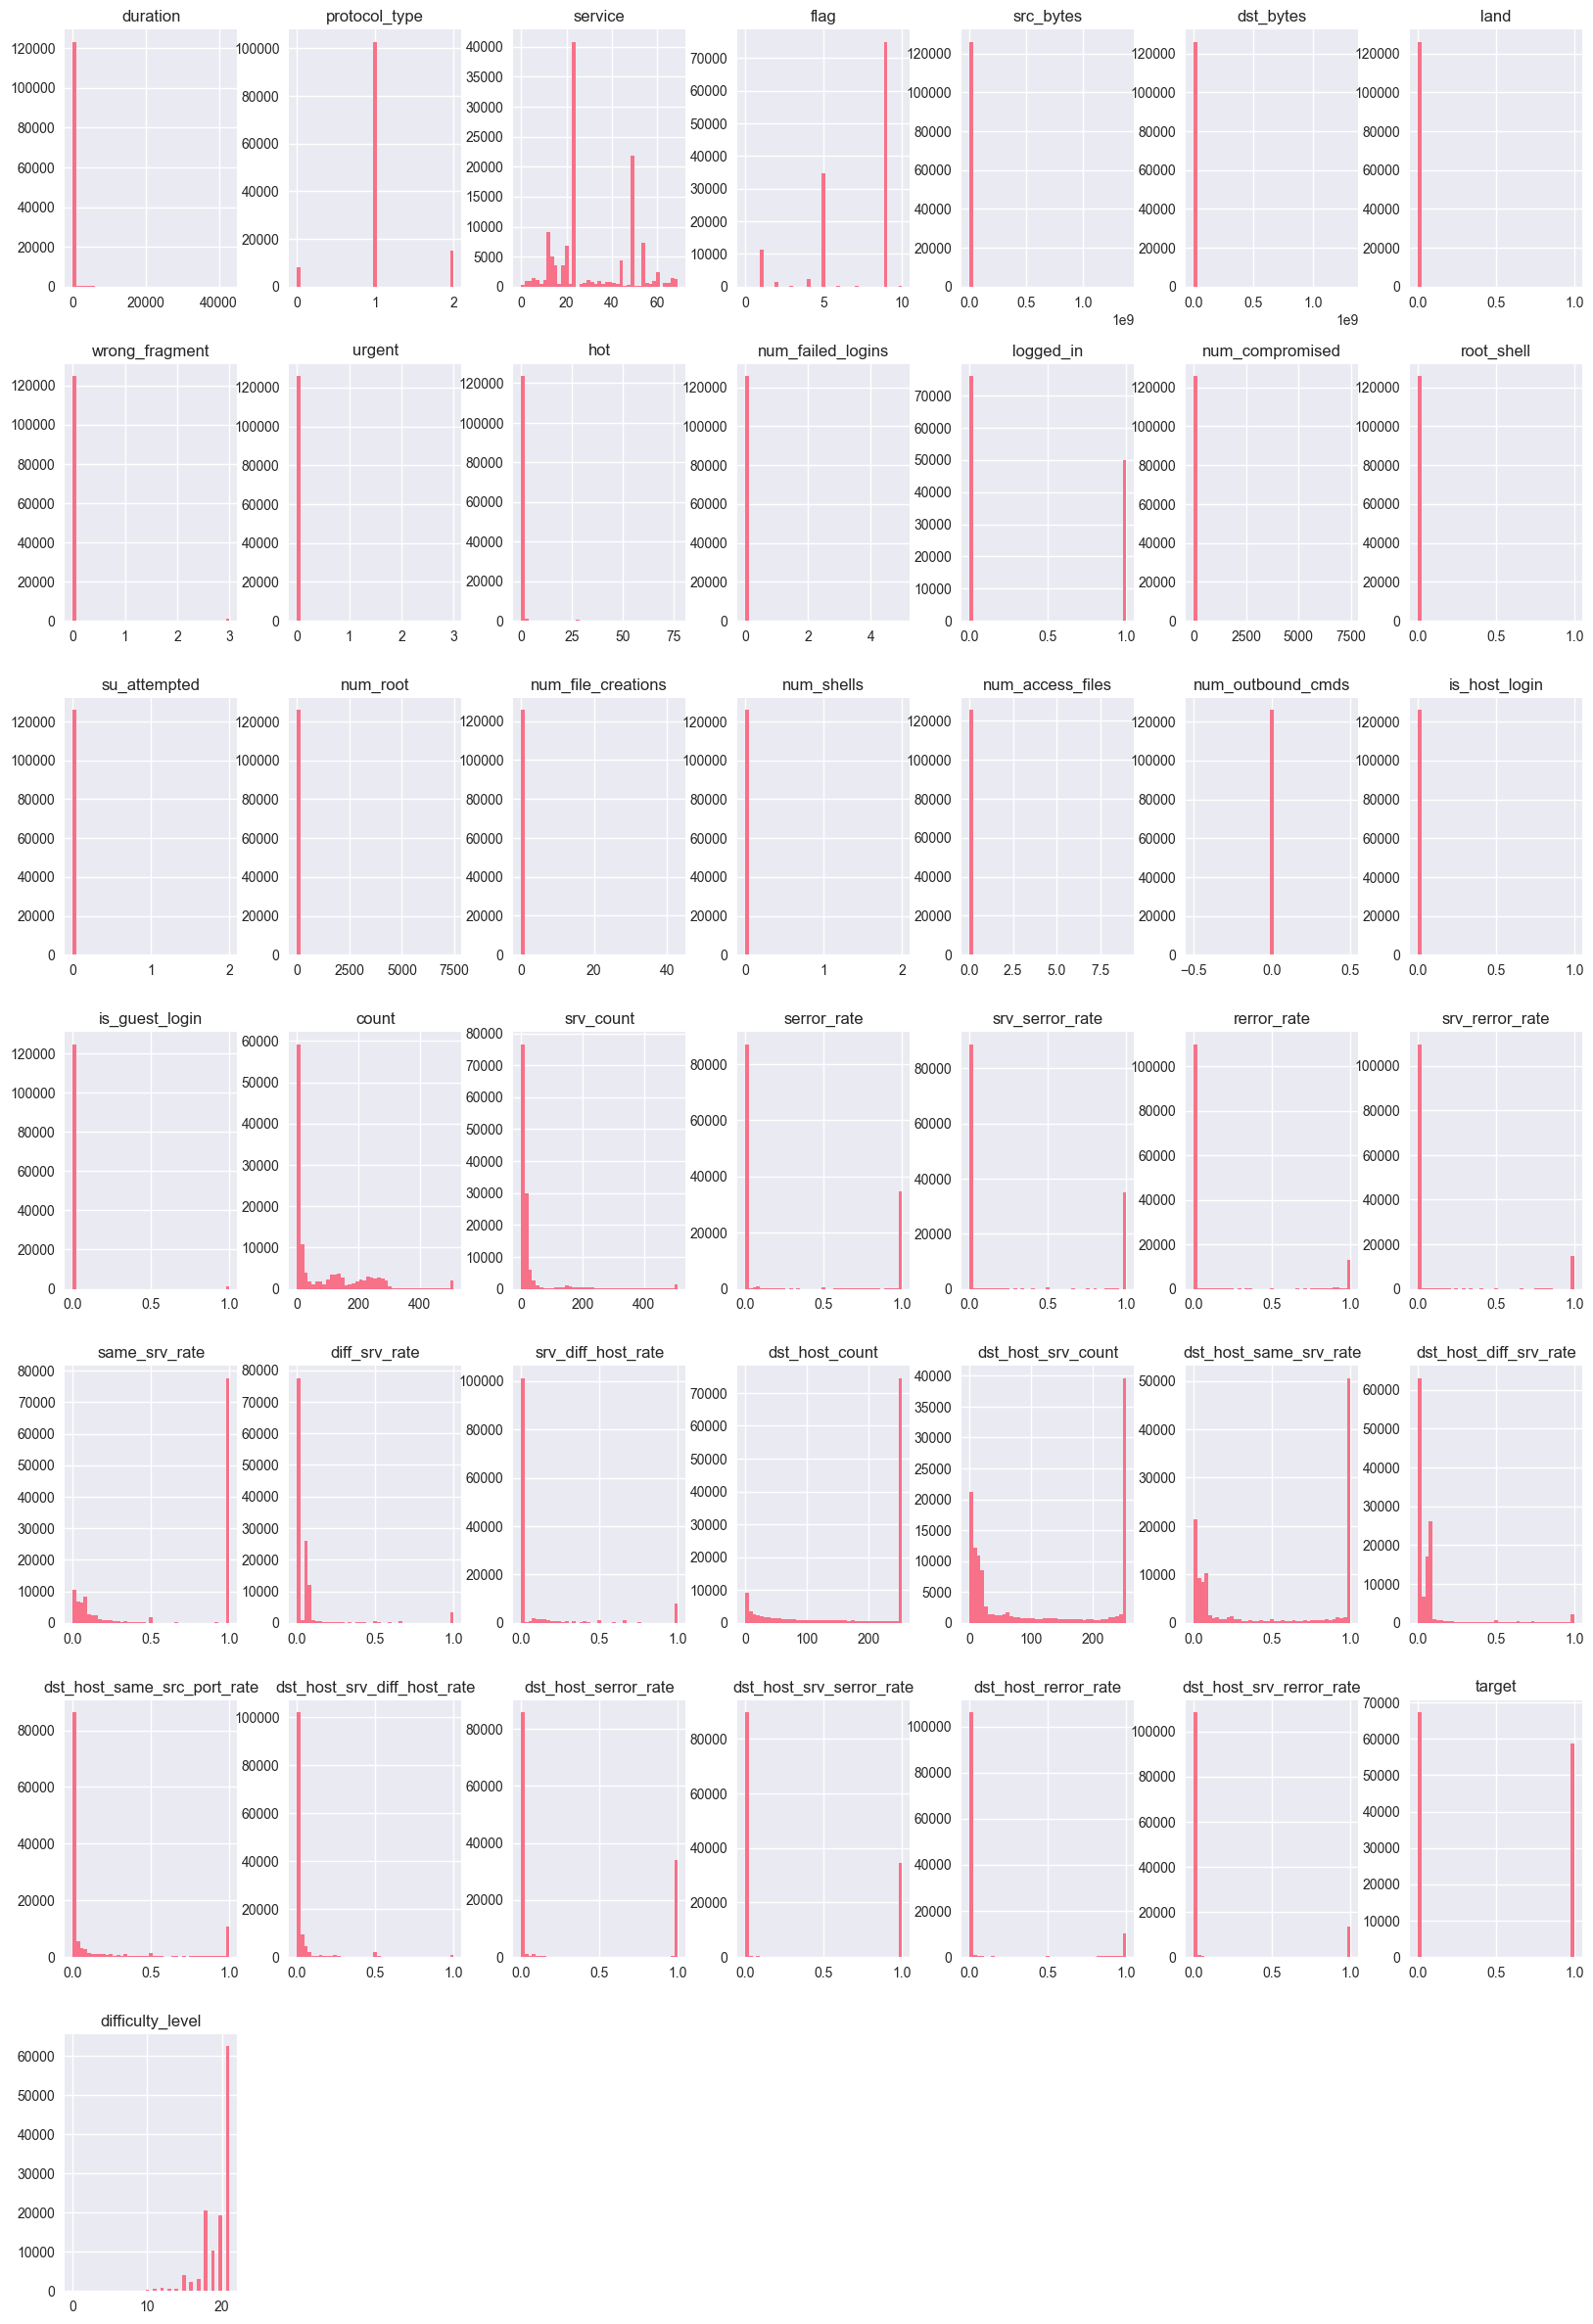

In [ ]:
train_df.hist(bins=43, figsize=(20, 30))

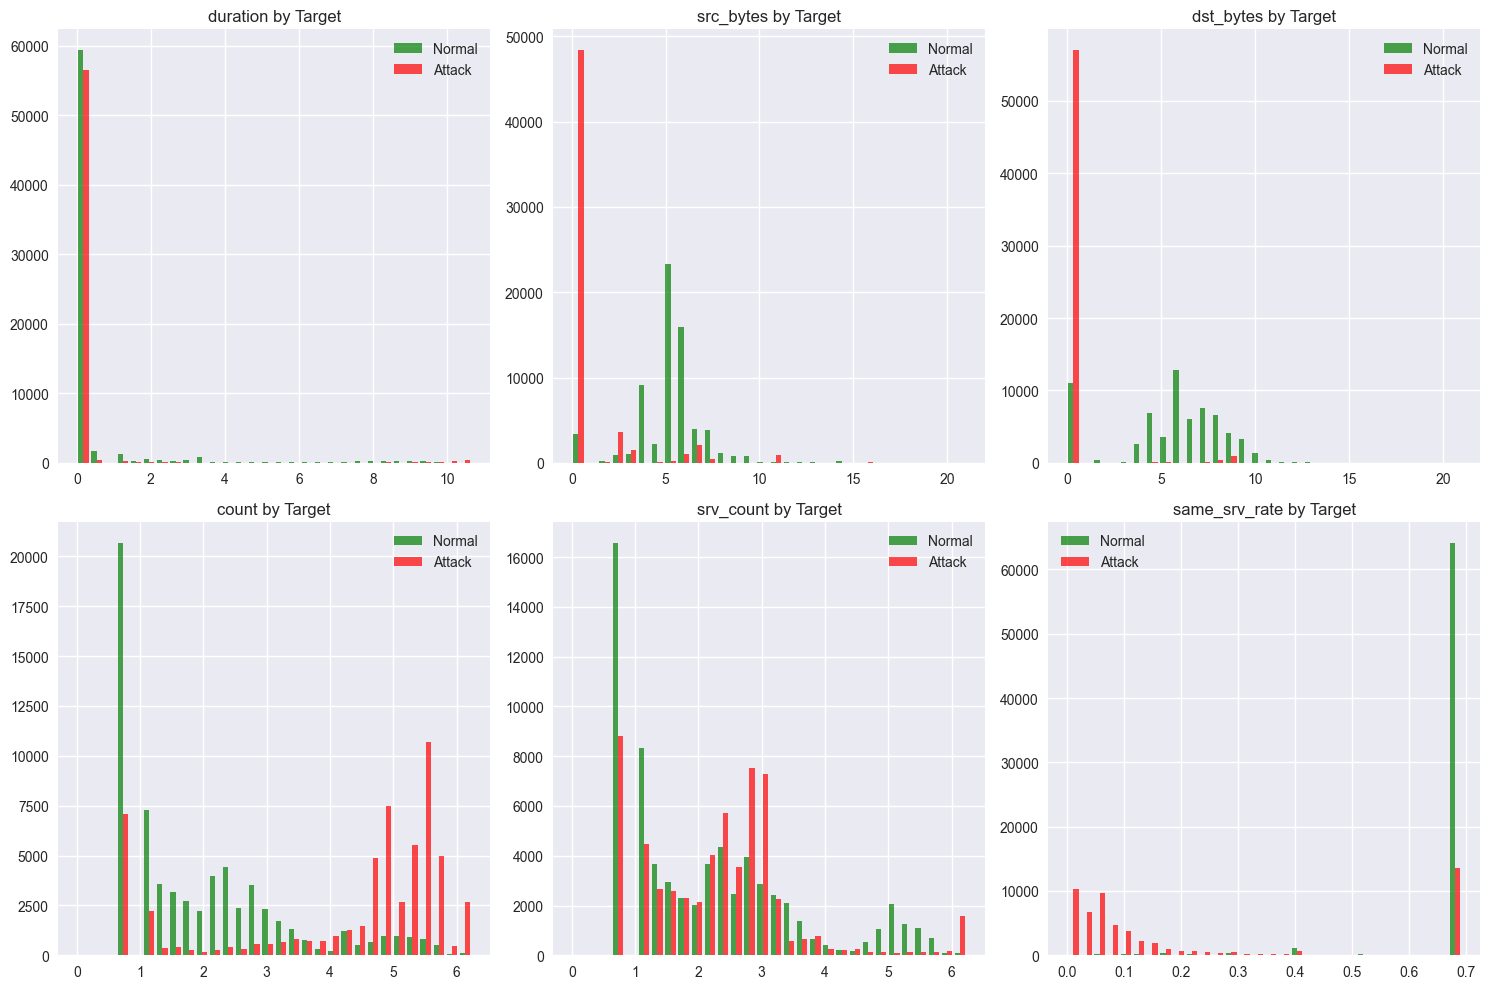

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(key_features):
    normal_data = np.log1p(train_df[train_df['target'] == 0][feature])
    attack_data = np.log1p(train_df[train_df['target'] == 1][feature])

    axes[i].hist([normal_data, attack_data], bins=30, alpha=0.7, label=['Normal', 'Attack'], color=['green', 'red'])
    axes[i].set_title(f'{feature} by Target')
    axes[i].legend()

plt.tight_layout()
plt.show()

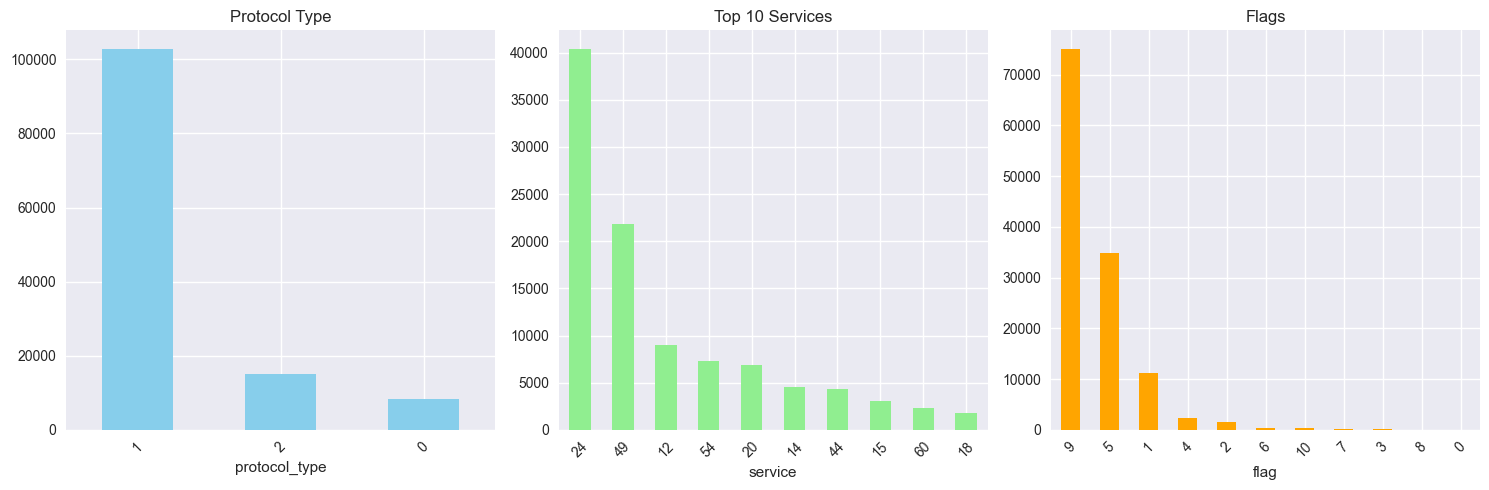

In [ ]:
# Visualize categorical variables
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Protocol type
train_df['protocol_type'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Protocol Type')
axes[0].tick_params(axis='x', rotation=45)

# Top 10 services
train_df['service'].value_counts().head(10).plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('Top 10 Services')
axes[1].tick_params(axis='x', rotation=45)

# Top flags
train_df['flag'].value_counts().plot(kind='bar', ax=axes[2], color='orange')
axes[2].set_title('Flags')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

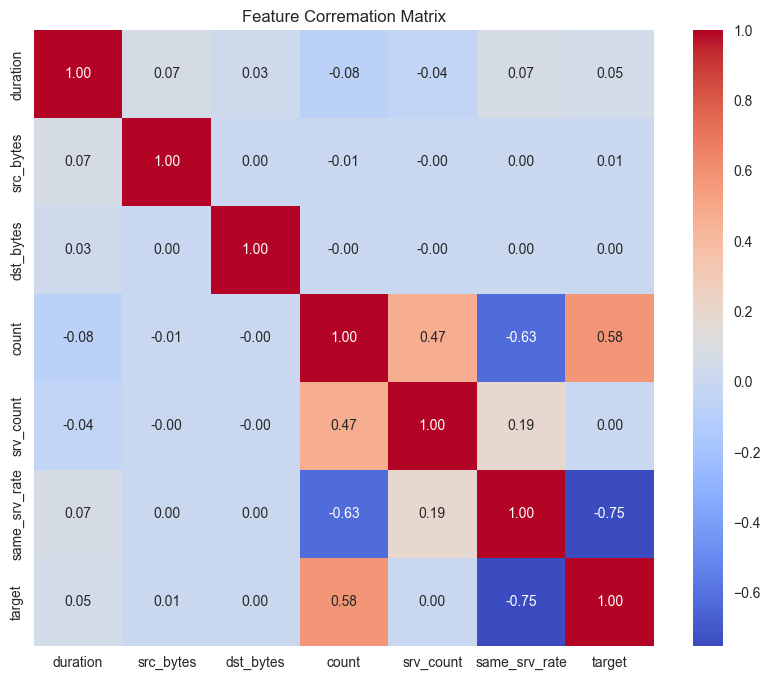

In [ ]:
corr_features = key_features + ['target']
corr_matrix = train_df[corr_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Corremation Matrix')
plt.show()

In [ ]:
print(corr_matrix['target'].abs().sort_values(ascending=False)[1:6])

same_srv_rate    0.751913
count            0.576444
duration         0.048785
src_bytes        0.005921
dst_bytes        0.004118
Name: target, dtype: float64


In [19]:
X_train = train_df.drop("target", axis=1) 
y_train = train_df["target"] 
X_test = test_df.drop("target", axis=1)
y_test = test_df["target"]

In [20]:
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

src_bytes                      0.566360
service                        0.468569
dst_bytes                      0.441080
flag                           0.369544
same_srv_rate                  0.368738
diff_srv_rate                  0.360097
dst_host_srv_count             0.334672
dst_host_same_srv_rate         0.311803
logged_in                      0.293332
dst_host_serror_rate           0.287024
dst_host_diff_srv_rate         0.285659
dst_host_srv_serror_rate       0.280844
serror_rate                    0.279148
srv_serror_rate                0.268333
count                          0.263877
dst_host_srv_diff_host_rate    0.186819
difficulty_level               0.152063
dst_host_count                 0.145329
dst_host_same_src_port_rate    0.133163
srv_diff_host_rate             0.099613
srv_count                      0.063189
dst_host_srv_rerror_rate       0.061923
protocol_type                  0.054955
rerror_rate                    0.037856
srv_rerror_rate                0.037498


<Axes: >

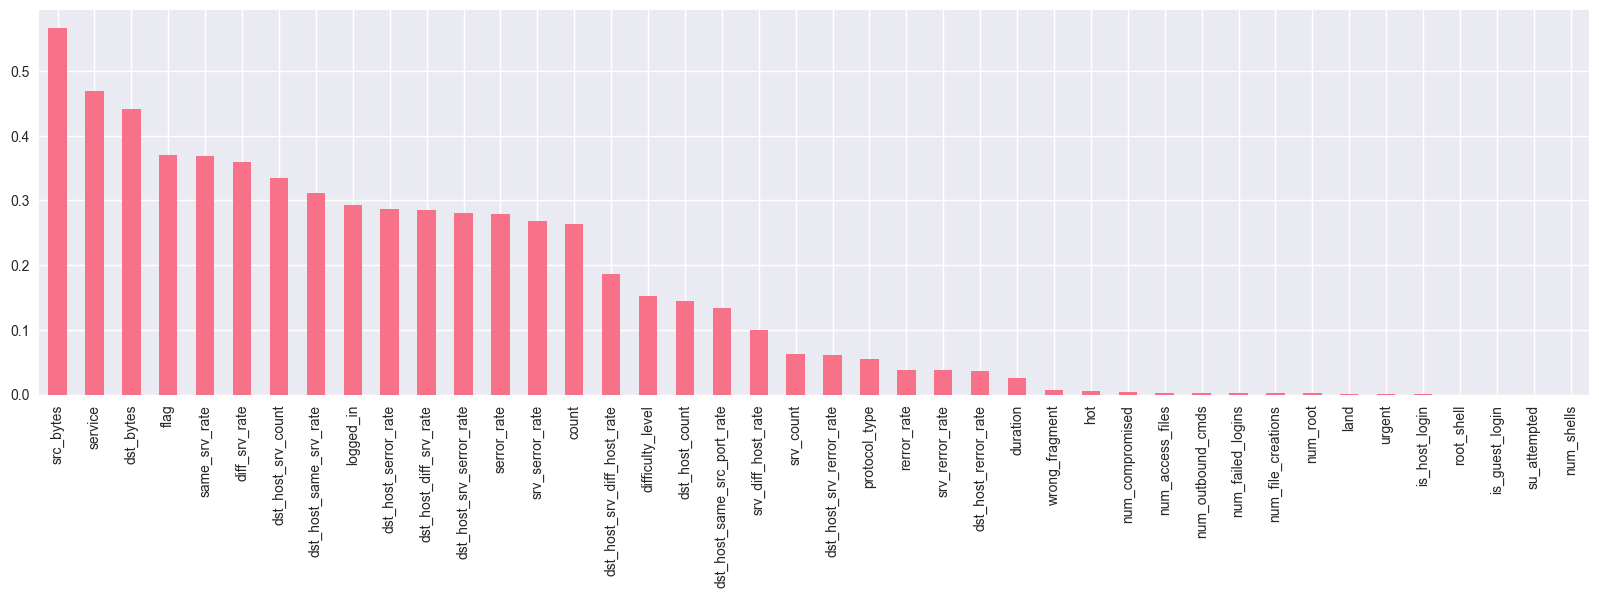

In [21]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 5))

In [ ]:
Select_features = SelectKBest(mutual_info_classif, k=30)
Select_features.fit(X_train, y_train)

,score_func,<function mut...0022B53371120>
,k,30


# Modeling

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [24]:
# scalling no need in desiontrees
dt_classifier = DecisionTreeClassifier(random_state=42, max_depth=5)
dt_classifier.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [25]:
y_pred = dt_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Desion tree accuracy: {accuracy: .4f}")

Desion tree accuracy:  0.9853


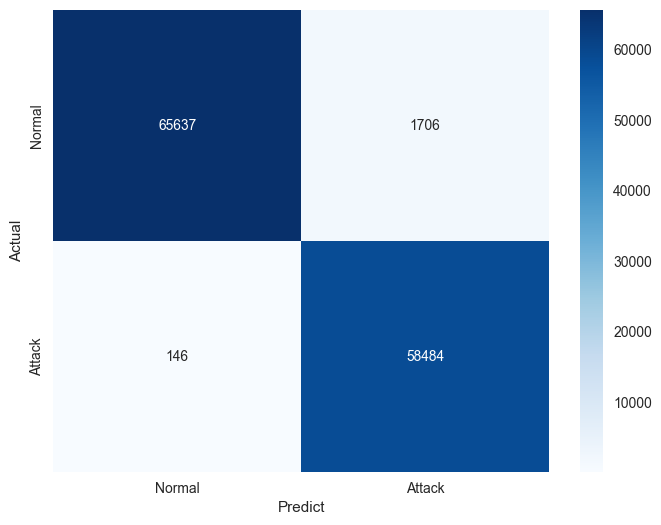

In [29]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.ylabel('Actual')
plt.xlabel('Predict')
plt.show()

🎯 Top 10 Most Important Features:
                     feature  importance
4                  src_bytes    0.777884
1              protocol_type    0.067064
41          difficulty_level    0.059475
32        dst_host_srv_count    0.047427
5                  dst_bytes    0.020282
33    dst_host_same_srv_rate    0.011008
11                 logged_in    0.010360
38  dst_host_srv_serror_rate    0.003758
24               serror_rate    0.000724
22                     count    0.000651


C:\Users\hp\AppData\Local\Temp\ipykernel_11764\2401276761.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance.head(10), x='importance', y='feature', palette='viridis')


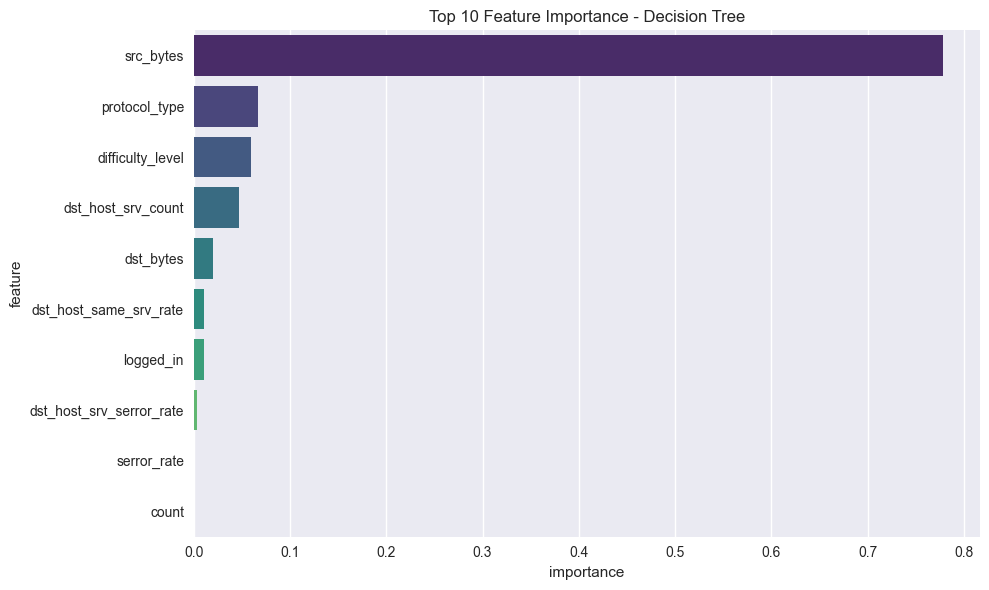

In [30]:
# See which features the tree found most important
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': dt_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("🎯 Top 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature', palette='viridis')
plt.title('Top 10 Feature Importance - Decision Tree')
plt.tight_layout()
plt.show()

In [32]:
# Experiment with different parameters
print("AI generated cell Trying different tree configurations...")

parameters = [
    {'max_depth': 3, 'criterion': 'gini'},
    {'max_depth': 5, 'criterion': 'entropy'},
    {'max_depth': 10, 'min_samples_split': 20},
    {'max_depth': None, 'min_samples_leaf': 10}  # Unlimited depth but minimum leaf size
]

for i, params in enumerate(parameters):
    dt = DecisionTreeClassifier(random_state=42, **params)
    dt.fit(X_train, y_train)
    y_pred_temp = dt.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_temp)
    print(f"Config {i+1}: {params} → Accuracy: {accuracy:.4f}")

AI generated cell Trying different tree configurations...
Config 1: {'max_depth': 3, 'criterion': 'gini'} → Accuracy: 0.9781
Config 2: {'max_depth': 5, 'criterion': 'entropy'} → Accuracy: 0.9890
Config 3: {'max_depth': 10, 'min_samples_split': 20} → Accuracy: 0.9990
Config 4: {'max_depth': None, 'min_samples_leaf': 10} → Accuracy: 0.9989
